## Przewidywanie bankructwa polskich przedsiębiorstw

Celem projektu jest zbudowanie modelu klasyfikacyjnego, który na podstawie wskaźników finansowych przewidzi upadłość firmy.

### Importowanie bibliotek i konfiguracja środowiska

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.io import arff

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from attributes import attributes_pl

# Ustawienia wyświetlania
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Ustawienia kolorów
COLOR_HEALTHY = '#1f77b4'
COLOR_BANKRUPT = '#d62728'

YEAR_TO_ANALYZE = 3 # od 1 do 5
print("Środowisko gotowe")
print(f"Analizowany rok: {YEAR_TO_ANALYZE}")

Środowisko gotowe
Analizowany rok: 3


### Wczytanie i unifikacja danych

Wczytanie danych z pliku `.arff`. Dane zawierają wskaźniki finansowe (Attr1 - Attr64) oraz etykietę klasy (`class`), gdzie:
* `0` - firma zdrowa
* `1` - bankrut

Następnie dane są dzielone zbiór na treningowy i testowy (proporcja 80/20).

In [2]:
file_path = f'data/{YEAR_TO_ANALYZE}year.arff'

try:
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    df['class'] = df['class'].astype(int)
    
    print(f"Wczytano dane dla roku {YEAR_TO_ANALYZE}")
    print(f"Wymiary: {df.shape[0]} wierszy, {df.shape[1]} kolumn")
    
    display(df.head(5))
    
except FileNotFoundError:
    print(f"BŁĄD: Nie odnaleziono pliku: {file_path}")

Wczytano dane dla roku 3
Wymiary: 10503 wierszy, 65 kolumn


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,0.531390,0.142330,0.219460,592.24,0.61630,2.4213,0.219460,0.122720,37.573,0.99690,0.295100,0.097402,0.75641,0.46359,0.50669,1.97370,0.32417,5.9473,0.224930,0.122720,100.820,3.6203,0.71453,0.295100,1.8079,123140.0000,0.46359,0.165010,0.212820,0.041124,0.165010,95.682,58.109,0.946210,0.90221,44.941,0.260030,0.145400,1.3480,0.41299,0.27622,1.0457,1.0458,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,0.383170,0.126470,0.171850,829.46,0.44004,2.1721,0.171850,0.107280,60.954,5.08890,0.175710,0.091295,NaN,0.17523,0.38442,44.59300,1.04860,4.0792,0.243840,0.109740,105.090,3.4733,3.38360,0.044076,1.6018,NaN,0.53962,0.027516,0.164060,0.074333,0.109690,149.750,88.801,0.546690,1.03300,62.678,0.144970,0.090503,1.5874,0.44849,0.28791,2.0044,2.0044,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,0.020219,0.030966,0.004572,2094.10,0.17430,4.4225,0.004572,0.003592,53.881,0.67451,0.040610,0.000468,0.23470,0.67566,0.15672,0.32153,1.71070,4.6220,0.036196,0.003592,65.345,5.5857,0.17960,0.040610,1.3425,NaN,0.67566,0.031907,0.844690,0.098528,0.031907,150.130,96.251,0.003168,2.32900,54.296,0.005769,0.004533,3.1599,0.22612,0.17903,2.3667,2.3667,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,0.069747,0.036812,0.024526,3299.40,0.11063,2.3129,0.024526,0.018876,86.317,0.62795,0.055446,0.018876,0.56944,0.56453,0.11063,0.44844,0.73869,4.2600,0.286240,0.018876,103.810,3.5161,0.12824,0.055446,1.3068,3.9624,0.64524,0.042673,0.178260,0.180500,0.042673,158.550,72.237,0.079819,0.90954,90.707,0.032141,0.024737,1.4504,0.35164,0.28440,1.5139,1.7303,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,0.633170,0.187800,0.233580,602.31,0.60600,2.4094,0.233580,0.174410,140.860,1.20390,0.234930,0.140590,0.00000,0.57250,0.49687,44.94700,1.18530,4.6033,0.306910,0.177840,122.090,2.9897,2.65740,0.236350,1.3393,4.5490,0.62769,0.176480,0.013769,0.054712,0.175420,192.450,51.585,0.364290,0.52685,171.050,0.216990,0.162030,1.7136,0.36891,0.33449,2.0256,2.1735,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


### Eksploracyjna analiza danych (EDA)

1.  **Analiza braków danych:** Sprawdzenie, które wskaźniki finansowe są najczęściej niekompletne.
2.  **Rozkład klas:** Weryfikacja, jak bardzo niezbalansowany jest zbiór (stosunek firm zdrowych do bankrutów).
3.  **Korelacje:** Szukanie cech, które mają najsilniejszy związek (dodatni lub ujemny) z bankructwem.

/tmp/ipykernel_97031/3271439735.py:15: UserWarning: The palette list has more values (25) than needed (20), which may not be intended.
  ax = sns.barplot(


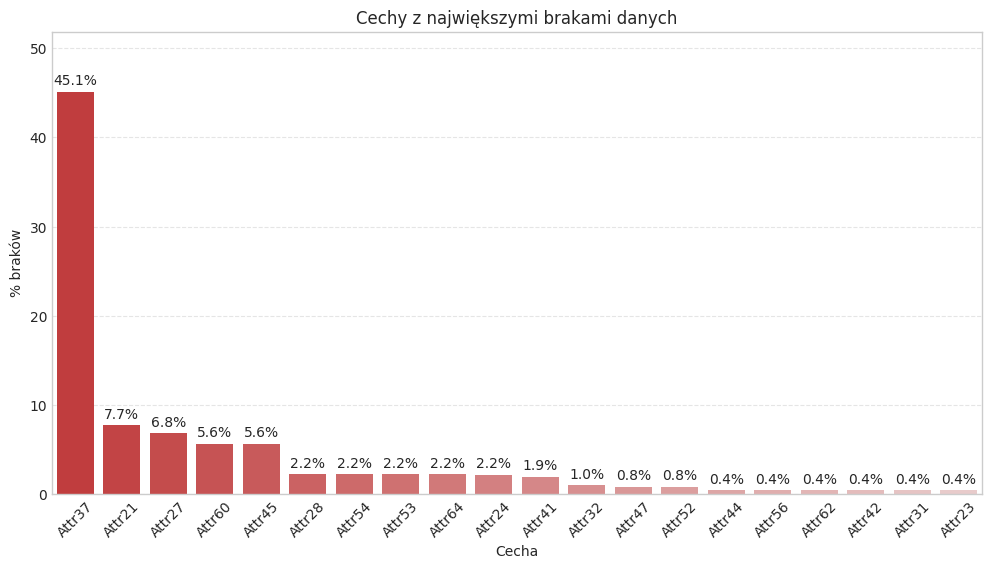

LEGENDA
Attr37: (aktywa obrotowe - zapasy) / zobowiązania długoterminowe
Attr21: przychody ze sprzedaży (n) / przychody ze sprzedaży (n-1)
Attr27: zysk z działalności operacyjnej / koszty finansowe
Attr60: przychody ze sprzedaży / zapasy
Attr45: zysk netto / zapasy
Attr28: kapitał obrotowy / aktywa trwałe
Attr54: kapitał stały / aktywa trwałe
Attr53: kapitał własny / aktywa trwałe
Attr64: przychody ze sprzedaży / aktywa trwałe
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr41: zobowiązania ogółem / ((zysk z dział. operacyjnej + amortyzacja) * (12/365))
Attr32: (zobowiązania bieżące * 365) / koszt własny sprzedaży
Attr47: (zapasy * 365) / koszt własny sprzedaży
Attr52: (zobowiązania krótkoterminowe * 365) / koszt własny sprzedaży
Attr44: (należności * 365) / przychody ze sprzedaży
Attr56: (przychody ze sprzedaży - koszt własny sprzedaży) / przychody ze sprzedaży
Attr62: (zobowiązania krótkoterminowe * 365) / przychody ze sprzedaży
Attr42: zysk z działalności operacyjnej / przychody 

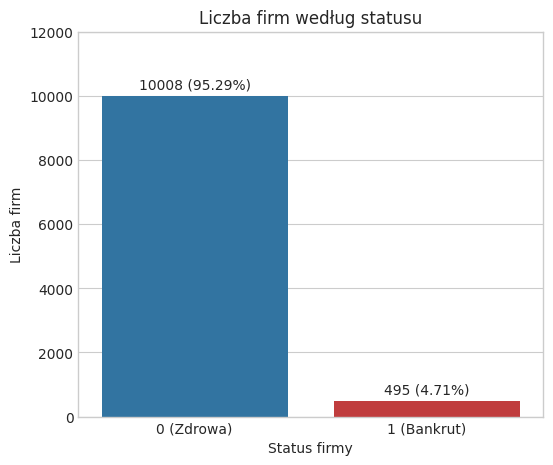

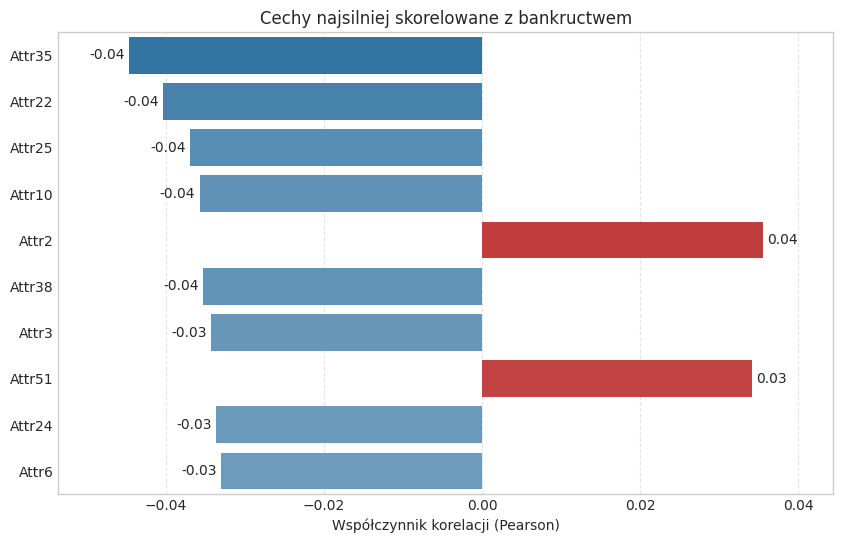

LEGENDA
Attr35: zysk na sprzedaży / aktywa ogółem
Attr22: zysk z działalności operacyjnej / aktywa ogółem
Attr25: (kapitał własny - kapitał zakładowy) / aktywa ogółem
Attr10: kapitał własny / aktywa ogółem
Attr2: zobowiązania ogółem / aktywa ogółem
Attr38: kapitał stały / aktywa ogółem
Attr3: kapitał obrotowy / aktywa ogółem
Attr51: zobowiązania krótkoterminowe / aktywa ogółem
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr6: zyski zatrzymane / aktywa ogółem


In [3]:
# Ustawienia kolorów
BINARY_PALETTE = [COLOR_HEALTHY, COLOR_BANKRUPT]

cmap_diverging = mcolors.LinearSegmentedColormap.from_list("CustomRdBu", [COLOR_HEALTHY, "white", COLOR_BANKRUPT])

# 1. ANALIZA BRAKÓW DANYCH
missing = df.isnull().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

if not missing.empty:
    top_missing = missing.head(20)
    
    ax = sns.barplot(
        x=top_missing.index, 
        y=top_missing.values, 
        hue=top_missing.index, 
        legend=False, 
        palette=sns.light_palette(COLOR_BANKRUPT, n_colors=25, reverse=True)
    )
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title(f'Cechy z największymi brakami danych')
    plt.xlabel('Cecha')
    plt.ylabel('% braków')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    
    max_missing = top_missing.max()
    limit = max_missing * 1.15 if max_missing > 0 else 10

    plt.ylim(0, limit)
    
    plt.show()
    
    print("LEGENDA")
    for attr in top_missing.index[:20]:
         print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")
else:
    print("Brak pustych wartości")

# 2. ROZKŁAD KLAS
plt.figure(figsize=(6, 5))

ax = sns.countplot(x='class', data=df, hue='class', legend=False, palette=BINARY_PALETTE)

total = len(df)

for container in ax.containers:
    labels = [f'{int(v.get_height())} ({v.get_height()/total*100:.2f}%)' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3)

plt.title(f'Liczba firm według statusu')
plt.xlabel('Status firmy')
plt.ylabel('Liczba firm')
plt.xticks([0, 1], ['0 (Zdrowa)', '1 (Bankrut)'])

max_height = max([p.get_height() for p in ax.patches])

plt.ylim(0, max_height * 1.2)

plt.show()

# 3. KORELACJE
correlations = df.corr()['class'].sort_values()
top_corr = correlations.abs().sort_values(ascending=False).head(11) 
top_corr_names = top_corr.index.tolist()

if 'class' in top_corr_names: top_corr_names.remove('class')

plt.figure(figsize=(10, 6))

corr_values = correlations[top_corr_names].values
norm = plt.Normalize(corr_values.min(), corr_values.max())
colors = cmap_diverging(norm(corr_values))

ax = sns.barplot(
    x=corr_values, 
    y=top_corr_names, 
    hue=corr_values, 
    legend=False, 
    palette=cmap_diverging
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Cechy najsilniej skorelowane z bankructwem')
plt.xlabel('Współczynnik korelacji (Pearson)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

min_val = corr_values.min()
max_val = corr_values.max()
padding = max(abs(min_val), abs(max_val)) * 0.2

plt.xlim(min_val - padding, max_val + padding)

plt.show()

print("LEGENDA")
for attr in top_corr_names:
    print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")

### Przetwarzanie i podział danych

Na podstawie analizy braków danych zdecydowano usunąć cechę `Attr37`, która posiada zbyt wiele pustych wartości, by je bezpiecznie uzupełniać.

Następnie:
1.  **Podział (Train/Test):** Dane dzielone są w proporcji 80/20 z zachowaniem proporcji klas (`stratify`).
2.  **Pipeline:**
    * **Imputacja:** Braki uzupełniane są medianą.
    * **Skalowanie:** Dane są standaryzowane (`StandardScaler`), co jest wymagane dla PCA i regresji logistycznej.

In [4]:
# 1. PRZYGOTOWANIE DANYCH
# Usunięcie cechy Attr37
if 'Attr37' in df.columns:
    X = df.drop(['class', 'Attr37'], axis=1)
    print("Usunięto kolumnę Attr37")
else:
    X = df.drop('class', axis=1)
    print("Kolumna Attr37 nie istnieje")

y = df['class']

feature_names_final = X.columns.tolist()
print(f"Liczba cech do analizy: {X.shape[1]}")

# 2. PODZIAŁ DANYCH
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego:  {X_test.shape}")
print(f"Liczba bankrutów w zbiorze testowym: {y_test.sum()} (na {len(y_test)} firm)")

# 3. PIPELINE PRZETWARZANIA DANYCH
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # mediana jest odporna na wartości odstające
    ('scaler', StandardScaler()) # średnia=0, odchylenie=1
])

# 4. DOPASOWANIE I TRANSFORMACJA DANYCH
# Pipeline jest dopasowywany do zbioru treningowego
X_train_scaled = preprocessor.fit_transform(X_train)
# Zbiór testowy jest transformowany na podstawie parametrów wyuczonych na zbiorze treningowym
X_test_scaled = preprocessor.transform(X_test)

# Zamiana na DataFrame (dla wygody operowania nazwami kolumn)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_final)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names_final)

Usunięto kolumnę Attr37
Liczba cech do analizy: 63
Rozmiar zbioru treningowego: (8402, 63)
Rozmiar zbioru testowego:  (2101, 63)
Liczba bankrutów w zbiorze testowym: 99 (na 2101 firm)


### Analiza głównych składowych (PCA)

Dane mają 63 wymiary, co utrudnia wizualizację. Zastosowano PCA, aby sprawdzić, czy bankruci tworzą oddzielne skupisko.

Wariancja wyjaśniona przez PC1: 16.76%
Wariancja wyjaśniona przez PC2: 12.76%
Suma informacji na wykresie: 29.52%


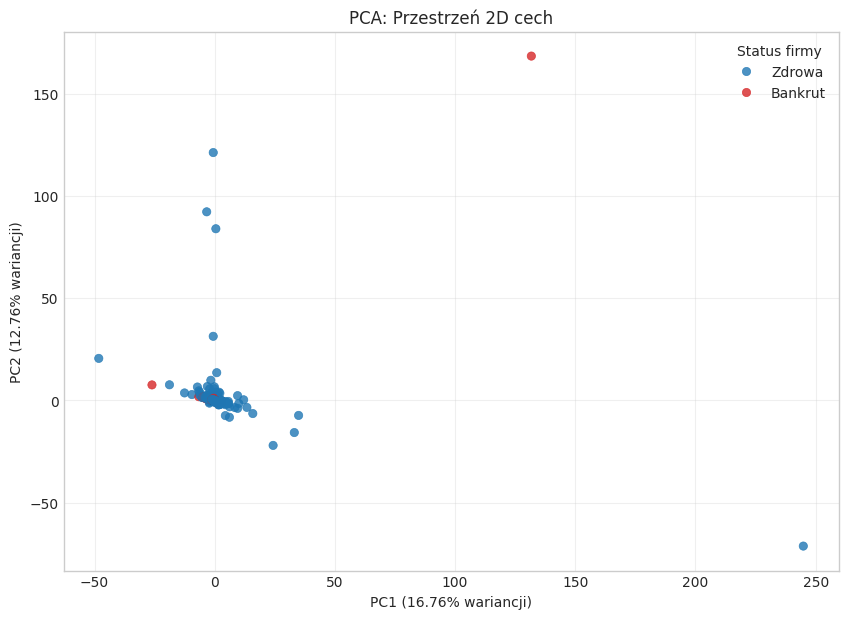

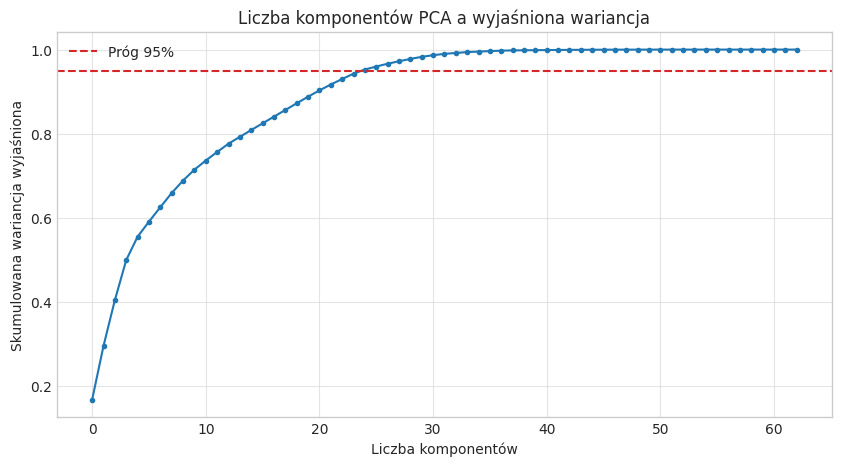

In [5]:
# Ustawienia kolorów
palette_dict = {'Zdrowa': COLOR_HEALTHY, 'Bankrut': COLOR_BANKRUPT}

# 1. URUCHOMIENIE PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['class'] = y_train.values
df_pca['Legenda'] = df_pca['class'].map({0: 'Zdrowa', 1: 'Bankrut'})

# 2. LICZBA WARIANCJI WYJAŚNIONEJ
evr = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniona przez PC1: {evr[0]:.2%}")
print(f"Wariancja wyjaśniona przez PC2: {evr[1]:.2%}")
print(f"Suma informacji na wykresie: {sum(evr):.2%}")

# 3. WIZUALIZACJA PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Legenda',
    data=df_pca, 
    palette=palette_dict,
    alpha=0.8,
    edgecolor=None
)
plt.title(f'PCA: Przestrzeń 2D cech')
plt.xlabel(f'PC1 ({evr[0]:.2%} wariancji)')
plt.ylabel(f'PC2 ({evr[1]:.2%} wariancji)')
plt.legend(title='Status firmy') 
plt.grid(True, alpha=0.3)
plt.show()

# 4. WYBÓR LICZBY KOMPONENTÓW PCA
pca_full = PCA().fit(X_train_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='.', linestyle='-', color=COLOR_HEALTHY)
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja wyjaśniona')
plt.title('Liczba komponentów PCA a wyjaśniona wariancja')
plt.axhline(y=0.95, color=COLOR_BANKRUPT, linestyle='--', label='Próg 95%')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Model bazowy (Baseline): Regresja logistyczna

Jako punkt odniesienia wytrenowana została regresja logistyczna.
Używany jest parametr `class_weight='balanced'`, aby zmusić model do zwracania uwagi na mniejszą klasę bankrutów (w przeciwnym razie model mógłby ignorować bankrutów i wciąż mieć wysoką ogólną dokładność).

Trenowanie modelu bazowego...
WYNIKI
ROC AUC: 0.7418
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      2002
           1       0.09      0.72      0.17        99

    accuracy                           0.66      2101
   macro avg       0.54      0.69      0.48      2101
weighted avg       0.94      0.66      0.76      2101



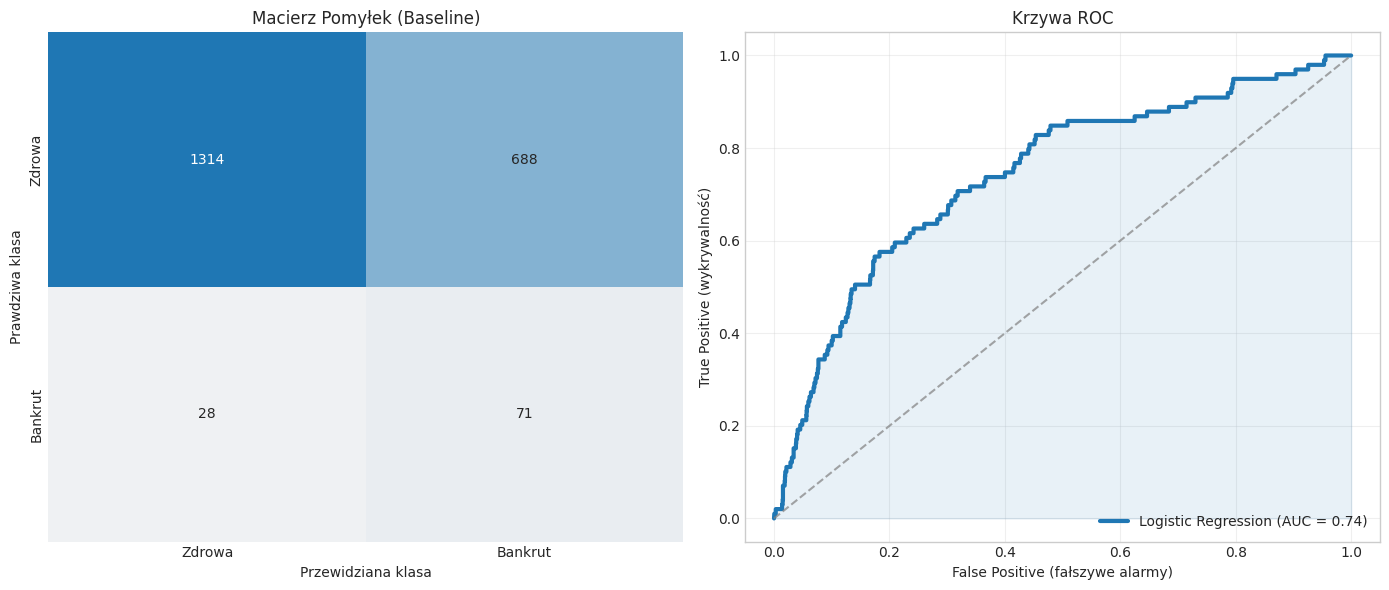

In [ ]:
# 1. TRENING
log_reg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

print("Trenowanie modelu bazowego...")
log_reg.fit(X_train_scaled, y_train)

# 2. PREDYKCJA
y_pred_base = log_reg.predict(X_test_scaled)
y_proba_base = log_reg.predict_proba(X_test_scaled)[:, 1]

# 3. WYNIKI
auc_base = roc_auc_score(y_test, y_proba_base)

print(f"WYNIKI")
print(f"ROC AUC: {auc_base:.4f}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred_base))

# 4. WIZUALIZACJE (macierz pomyłek i krzywa ROC)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Macierz Pomyłek
cmap_cm = sns.light_palette(COLOR_HEALTHY, as_cmap=True)

cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_cm, cbar=False, ax=ax[0])

ax[0].set_title('Macierz pomyłek')
ax[0].set_xlabel('Przewidziana klasa')
ax[0].set_ylabel('Prawdziwa klasa')
ax[0].set_xticklabels(['Zdrowa', 'Bankrut'])
ax[0].set_yticklabels(['Zdrowa', 'Bankrut'])

fpr, tpr, thresholds = roc_curve(y_test, y_proba_base)

ax[1].plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_base:.2f})', color=COLOR_HEALTHY, linewidth=3)
ax[1].fill_between(fpr, tpr, color=COLOR_HEALTHY, alpha=0.1)
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7) 
ax[1].set_xlabel('False Positive (fałszywe alarmy)')
ax[1].set_ylabel('True Positive (wykrywalność)')
ax[1].set_title('Krzywa ROC')
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()